In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import trange
import numpy as np
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
dev

'cuda'

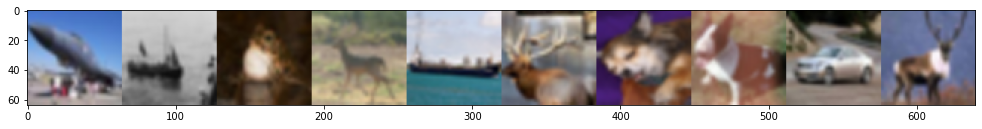

In [2]:
trans = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                            transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
dataset = CIFAR10('./dataset/', download=False, train=True, transform=trans)
# cars_idx = np.array(dataset.targets) == 1
# dataset.targets = list(np.array(dataset.targets)[cars_idx])
# dataset.data = dataset.data[cars_idx]

BS = 128
dtld = DataLoader(dataset, batch_size=BS, shuffle=True)
a = next(iter(dtld))
def implot(imgs, losses=False, save=False):
    imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy()
    img = np.concatenate(imgs, axis=1)
    
    fig, axs = plt.subplots(1 + losses)
    fig.set_size_inches((17, 6))
    if losses:
        axs[0].plot(g_losses, label='Generator losses')
        axs[0].plot(d_losses, label='Discriminator losses')
        axs[1].imshow(img)
    else:
        axs.imshow(img)
    plt.show()
    if save:
        fig.savefig(f'./images/epoch_{epoch}')
implot(a[0][:10])

In [18]:
class PrintShape(nn.Module):
    def __init__(self):
        super(PrintShape, self).__init__()
    def forward(self, x):
        print(x.shape)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def block(in_c, out_c, bn=True):
            b = [
                nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False)
            ]
            if bn:
                b.append(nn.BatchNorm2d(out_c))
            b.append(nn.LeakyReLU(.2, inplace=True))
            return b

        self.conv = nn.Sequential(
            *block(3, 64, bn=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.flat = nn.Flatten()
    def forward(self, x):
        x = self.conv(x)
        return self.flat(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_c, out_c, kernel=4, stride=2, padding=1):
            return [
                nn.ConvTranspose2d(in_c, out_c, kernel, stride, padding, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
        self.conv = nn.Sequential(
            *block(100, 512, padding=0),
            *block(512, 256),
            *block(256, 128),
            *block(128, 64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.conv(x.view((-1, 100, 1, 1)))

g = Generator().to(dev)
d = Discriminator().to(dev)
g_losses = []
d_losses = []
d(g(torch.randn((BS, 100), device=dev))).shape
# g(torch.randn((BS, 100), device=dev)).shape

torch.Size([128, 1])

In [19]:
def train_test_loop(dtld, train=True):
    for i, (x, _) in enumerate(dtld):
        x = x.to(dev)
        BS = x.shape[0]

        # z = (torch.randn((BS, 100), device=dev) - .5) / .5
        z = torch.randn((BS, 100), device=dev)
        ones, zeros = torch.full([BS], .9, device=dev), torch.zeros((BS), device=dev)
        gen_imgs = g(z)
        
        # Train generator
        for p in g.parameters():
            p.grad = None
        y_hat = d(gen_imgs).reshape((-1))
        g_loss = g_crit(y_hat, ones)
        g_loss.backward()
        g_optim.step()

        # Train discriminator
        for p in d.parameters():
            p.grad = None
        ones_hat, zeros_hat = d(x).reshape((-1)), d(gen_imgs.detach()).reshape((-1))
        d_loss = (d_crit(ones_hat, ones) + d_crit(zeros_hat, zeros)) / 2
        d_loss.backward()
        d_optim.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

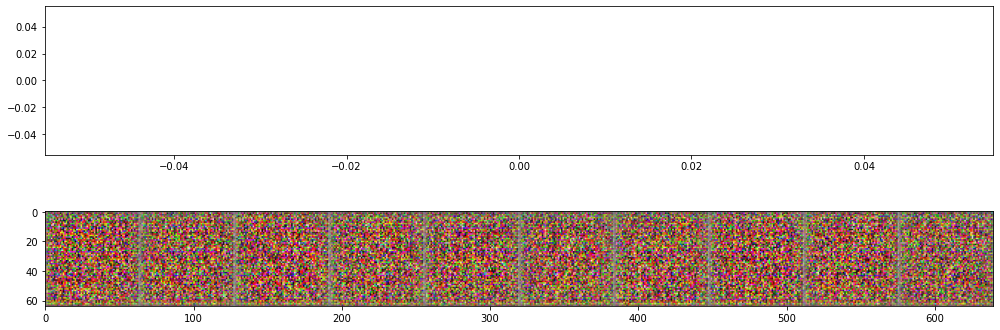

D_losses=0.2264 | G_losses=3.2783:   1%|          | 1/100 [02:05<3:26:25, 125.10s/it]

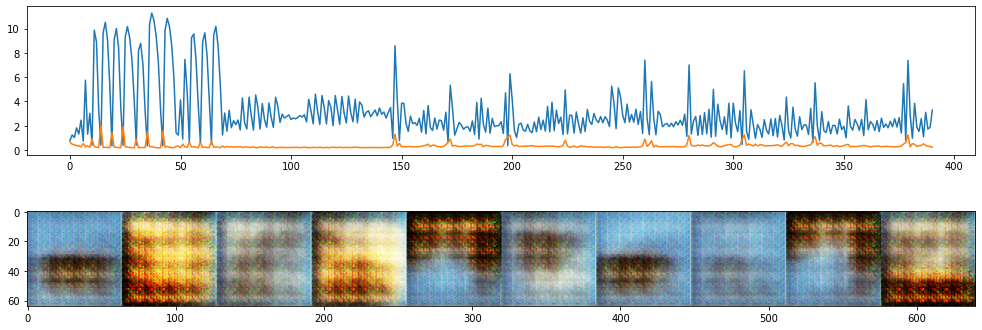

D_losses=0.4362 | G_losses=5.4266:   2%|▏         | 2/100 [04:10<3:24:38, 125.29s/it]

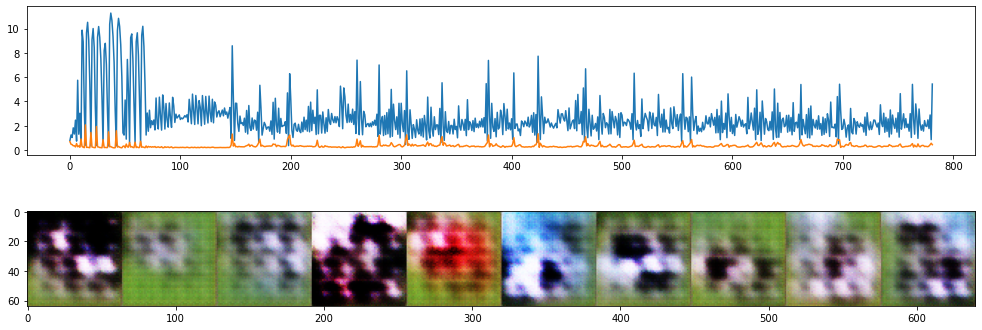

D_losses=0.2421 | G_losses=2.4696:   3%|▎         | 3/100 [06:15<3:22:35, 125.32s/it]

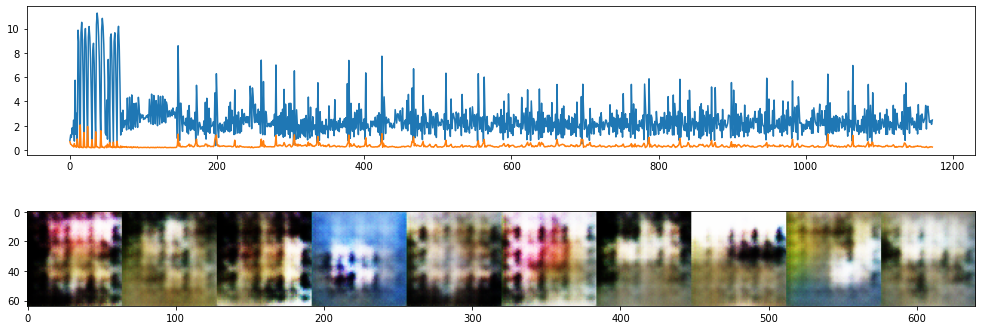

D_losses=0.2299 | G_losses=2.5312:   4%|▍         | 4/100 [08:20<3:20:22, 125.24s/it]

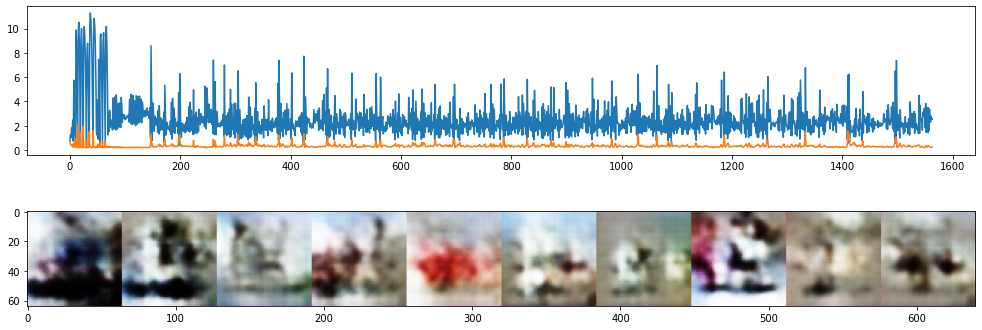

D_losses=0.2246 | G_losses=2.4624:   5%|▌         | 5/100 [10:26<3:18:11, 125.17s/it]

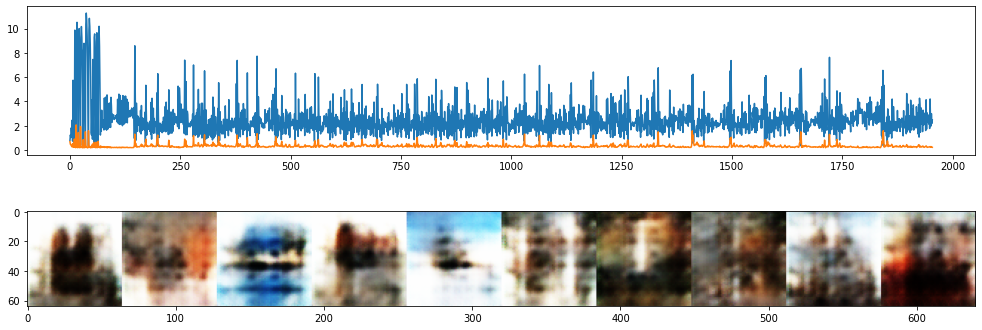

D_losses=0.4089 | G_losses=3.8149:   6%|▌         | 6/100 [12:31<3:16:09, 125.21s/it]

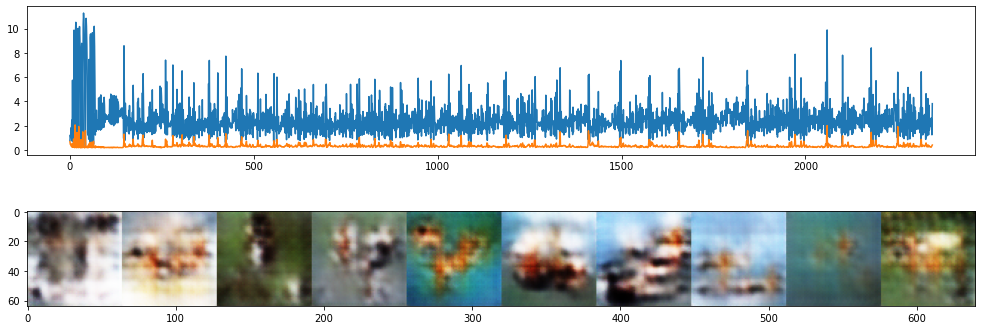

D_losses=0.3188 | G_losses=2.7680:   7%|▋         | 7/100 [14:36<3:13:50, 125.06s/it]

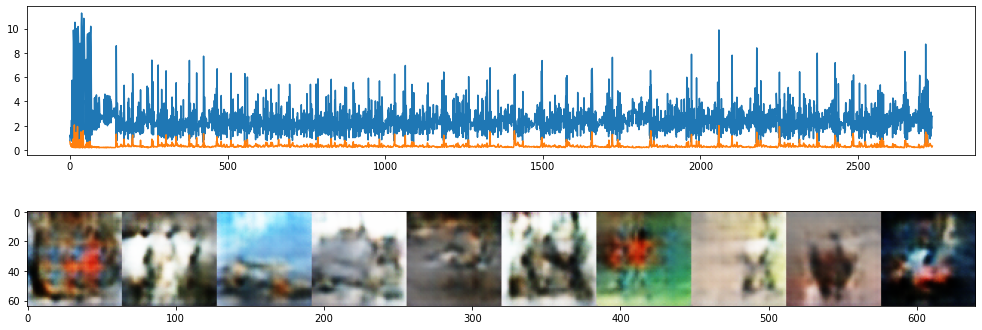

D_losses=0.1971 | G_losses=3.3547:   8%|▊         | 8/100 [16:41<3:11:48, 125.09s/it]

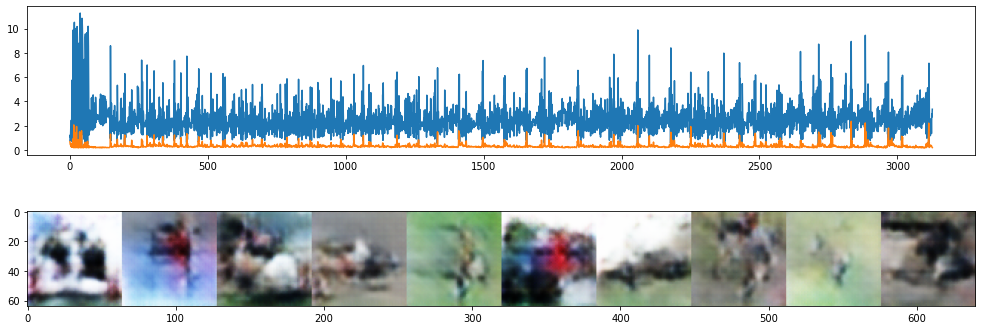

D_losses=0.3518 | G_losses=1.3044:   9%|▉         | 9/100 [18:46<3:09:40, 125.06s/it]

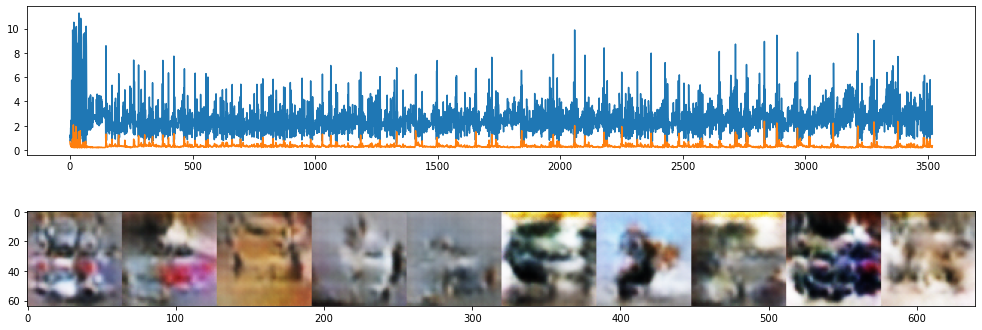

D_losses=0.1821 | G_losses=6.3532:  10%|█         | 10/100 [20:51<3:07:29, 124.99s/it]

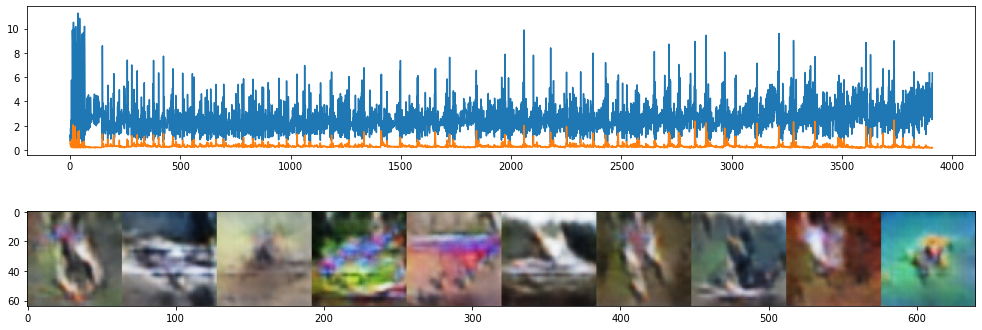

D_losses=0.1841 | G_losses=3.9482:  11%|█         | 11/100 [22:56<3:05:24, 125.00s/it]

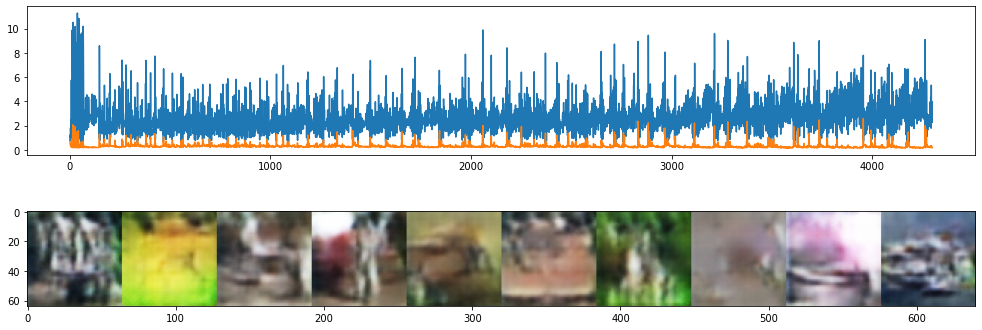

D_losses=0.1872 | G_losses=3.5326:  12%|█▏        | 12/100 [25:00<3:03:12, 124.92s/it]

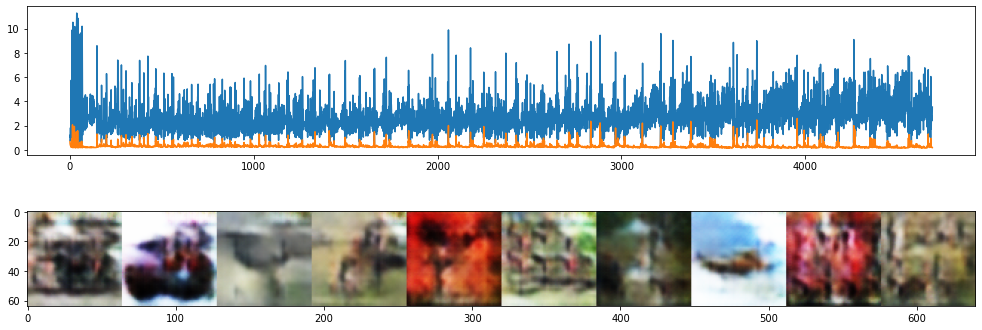

D_losses=0.5491 | G_losses=3.7919:  13%|█▎        | 13/100 [27:05<3:01:13, 124.99s/it]

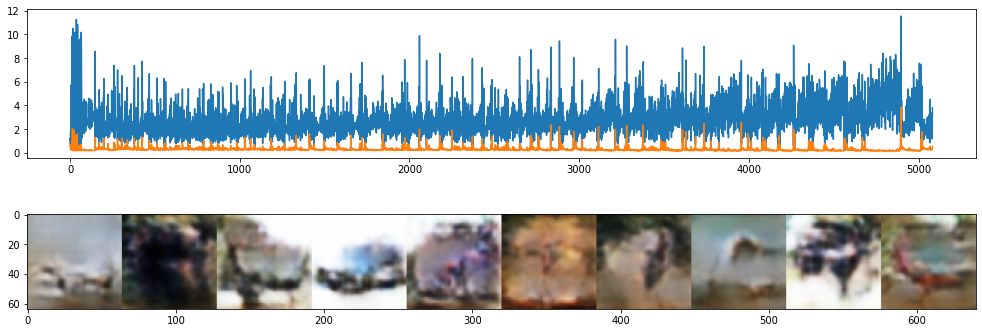

D_losses=0.2873 | G_losses=1.6810:  14%|█▍        | 14/100 [29:11<2:59:11, 125.02s/it]

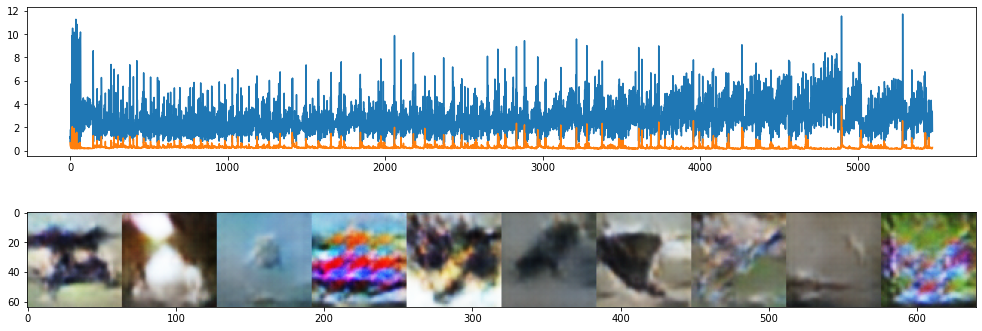

D_losses=0.1745 | G_losses=4.3540:  15%|█▌        | 15/100 [31:16<2:57:14, 125.11s/it]

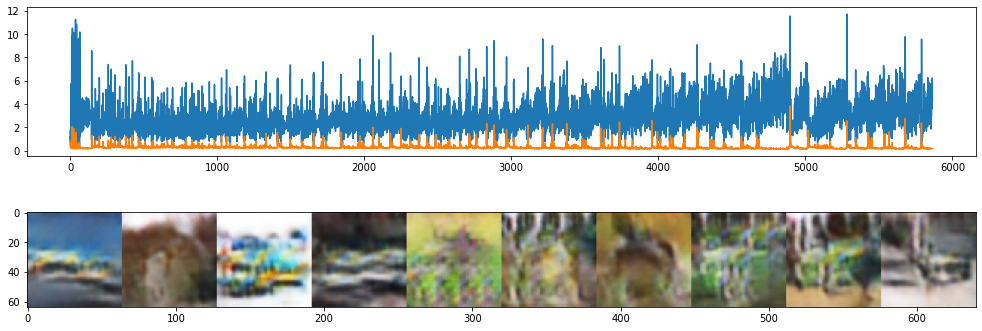

D_losses=0.3684 | G_losses=1.3959:  16%|█▌        | 16/100 [33:21<2:55:20, 125.25s/it]

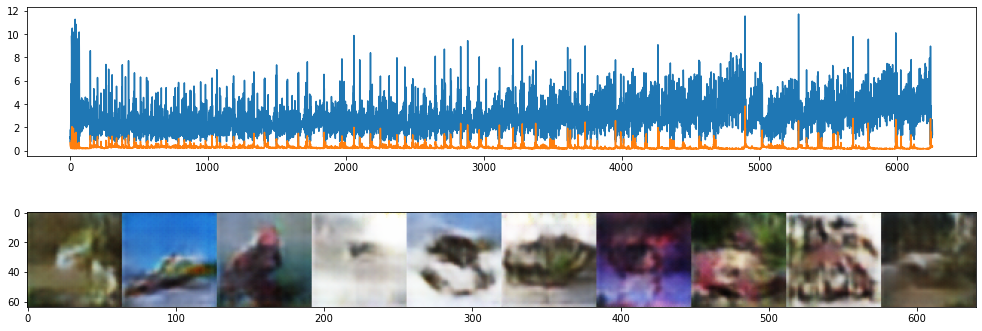

D_losses=0.2382 | G_losses=3.0137:  17%|█▋        | 17/100 [35:27<2:53:24, 125.35s/it]

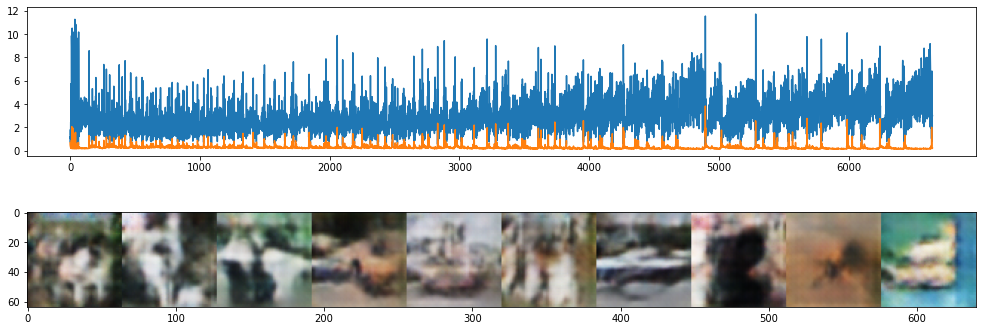

D_losses=0.1911 | G_losses=5.2539:  18%|█▊        | 18/100 [37:32<2:51:16, 125.32s/it]

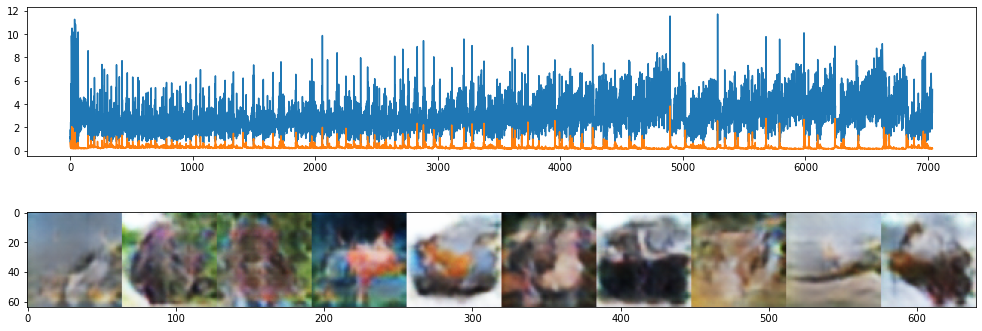

D_losses=0.1831 | G_losses=3.5254:  19%|█▉        | 19/100 [39:37<2:49:00, 125.19s/it]

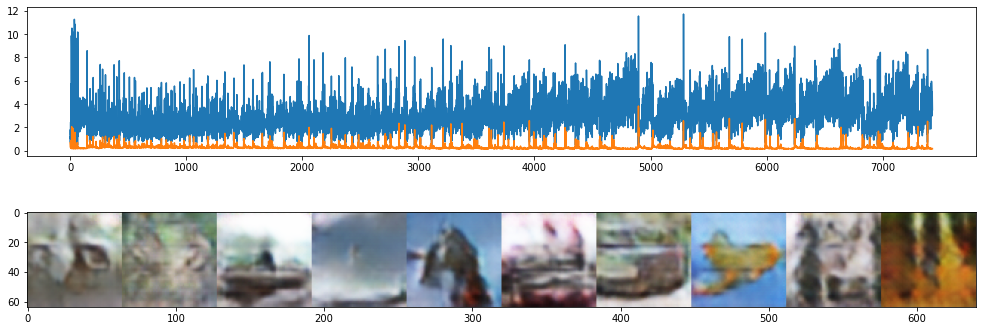

D_losses=0.2307 | G_losses=3.8599:  20%|██        | 20/100 [41:42<2:46:46, 125.08s/it]

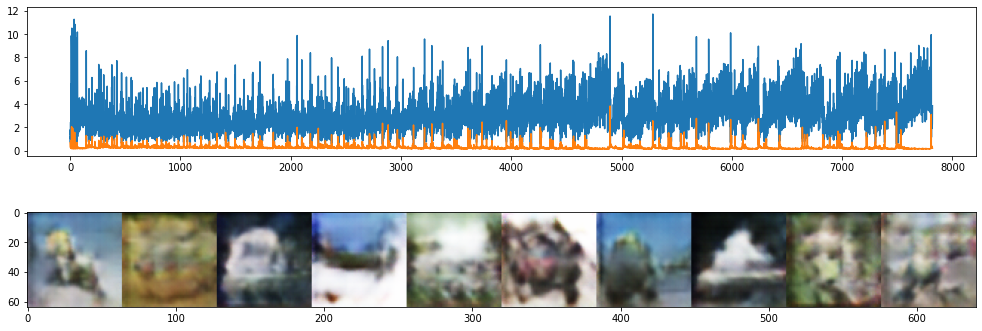

D_losses=0.2136 | G_losses=4.0937:  22%|██▏       | 22/100 [45:52<2:42:30, 125.00s/it]

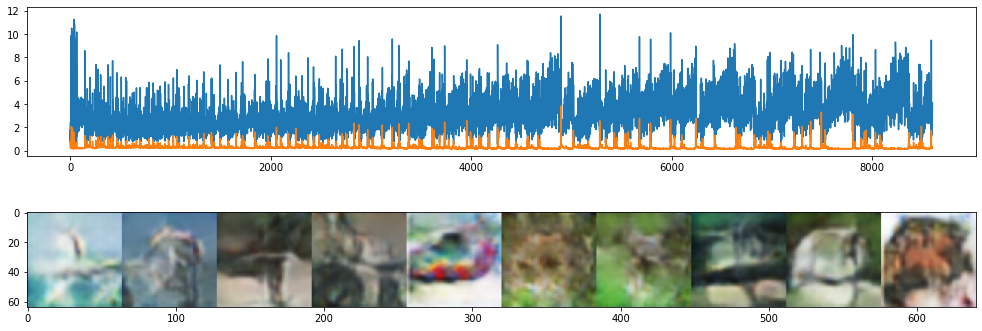

D_losses=0.2344 | G_losses=2.0491:  23%|██▎       | 23/100 [47:57<2:40:23, 124.98s/it]

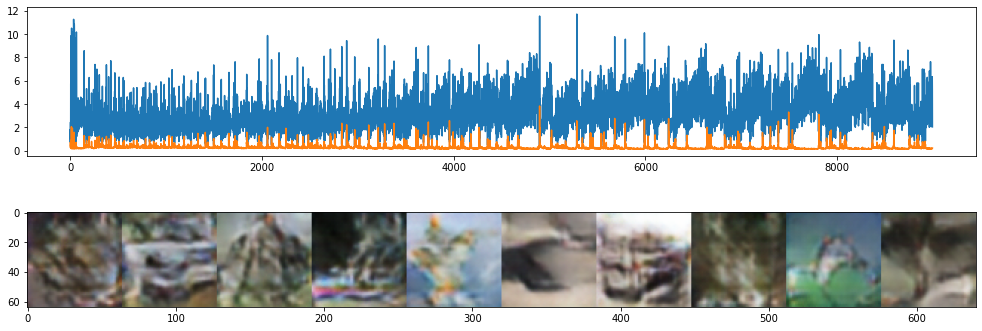

D_losses=0.3128 | G_losses=1.4111:  24%|██▍       | 24/100 [50:02<2:38:15, 124.94s/it]

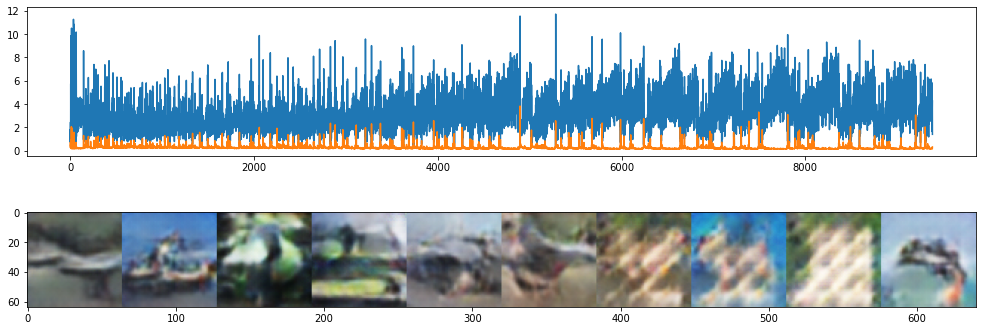

D_losses=0.1760 | G_losses=4.5542:  25%|██▌       | 25/100 [52:07<2:36:09, 124.93s/it]

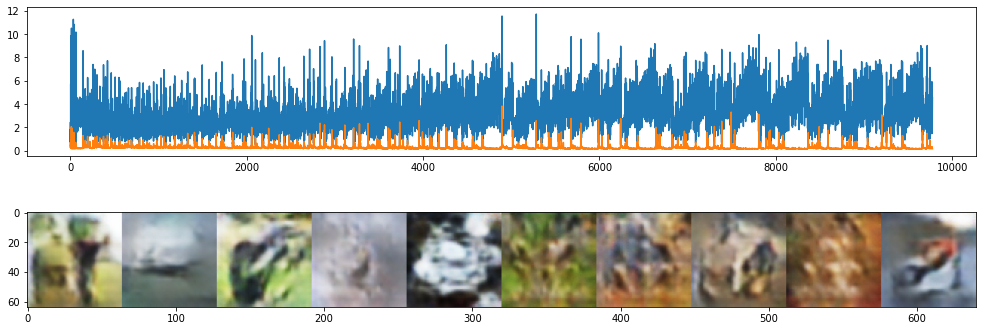

D_losses=0.1760 | G_losses=4.5542:  25%|██▌       | 25/100 [52:54<2:38:43, 126.98s/it]


KeyboardInterrupt: 

In [20]:
g_crit = nn.BCELoss()
d_crit = nn.BCELoss()
g_optim = torch.optim.Adam(g.parameters(), lr=2e-4, betas=(.5, .999))
d_optim = torch.optim.Adam(d.parameters(), lr=2e-4, betas=(.5, .999))

epochs = 100

for epoch in (t := trange(epochs)):
    implot(g(torch.randn((BS, 100), device=dev))[:10], losses=True, save=True)
    save()
    train_test_loop(dtld)
    t.set_description(f'D_losses=%.4f | G_losses=%.4f' % (d_losses[-1], g_losses[-1]))

In [ ]:
checkpoint = torch.load('checkpoint.pth') 
load = False
if load:
    g.load_state_dict(checkpoint['g_state_dict'])
    d.load_state_dict(checkpoint['d_state_dict'])
    g_optim.load_state_dict(checkpoint['g_optim_state_dict'])
    d_optim.load_state_dict(checkpoint['d_optim_state_dict'])
    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']

In [45]:
def save():
    torch.save({
                'epoch': epoch,
                 'g_state_dict': g.state_dict(),
                'd_state_dict': d.state_dict(),
                'g_optim_state_dict': g_optim.state_dict(),
                'd_optim_state_dict': d_optim.state_dict(),
                'g_losses': g_losses,
                'd_losses': d_losses,
                }, 'checkpoint.pth')
save()

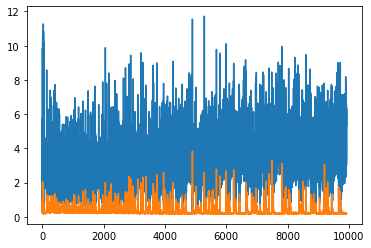

In [21]:
plt.plot(g_losses, label='Generator losses')
plt.plot(d_losses, label='Discriminator losses')
plt.show()

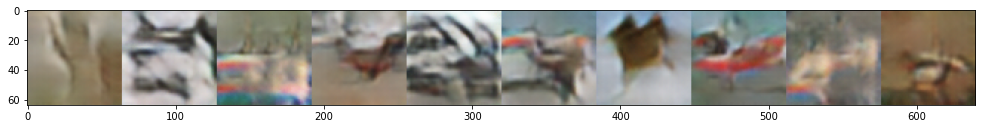

In [46]:
implot(g(torch.randn((128, 100), device=dev))[:10])